Esta forma esta bien para entrenar los modelos basados en tensores, pero no vale para pytorch.

# 1. Descargamos las librerias necesarias para la realización del script




In [1]:
################  TRANSFORMERS ################
!pip  install transformers --quiet
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import Trainer
!pip install transformers[torch] --quiet
!pip install accelerate -U --quiet
################  DATASETS ################
!pip install Datasets --quiet
from datasets import DatasetDict, Dataset
# Librería para montar drive en GoogleColab y descargar el dataset que vamos a usar:
from google.colab import drive  #Montador de drive

In [2]:
# Importamos otros modulos que necesitaremos para nuestra aproximación:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
################  MÉTRICAS ################
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Librería usada para la división del conjunto de datos en 3 conjuntos (Entrenamiento, Validación y Test)
from sklearn.model_selection import train_test_split
import gc

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# 2. Importamos el dataset







In [3]:
# 1.Obtenemos de drive el dataframe con el que vamos a trabajar
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/datasets/01 Exist2021_Esp.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#2.Cambiamos el nombre de las columnas e eliminamos aquellas que no necesitamos como el id, el testcase, etc. Nos vamos a quedar tan solo con el texto y las labels
columns_to_remove = ['test_case', 'id', 'source','language','task1']
df = df.rename(columns = {"task2": "label"}).drop(columns=columns_to_remove, axis=1)
df.head()

,text,label
0,Nadie te va a tratar tan bien como un hombre q...,sexual-violence
1,"@lindagisela74 Que rica putita obediente, afor...",stereotyping-dominance
2,@BicireporteraDF Yo lo hice a los 18 años por ...,non-sexist
3,las cosas q sueño son indicios de que yo enrea...,non-sexist
4,"Pero a la niña le gustó desde que lo vió, así ...",non-sexist


In [5]:
#4. Cambiamos los valores nominales de sexista y no sexista a valores numéricos
df['label'] = df['label'].replace(['non-sexist','sexual-violence', 'stereotyping-dominance', 'misogyny-non-sexual-violence', 'ideological-inequality','objectification'],[0, 1, 2 , 3, 4, 5])

In [6]:
#Eliminamos cualquier fila que haya podido quedar en blanco:
df = df.dropna()
# Y revisamos como ha quedado el dataframe:
df.head()

,text,label
0,Nadie te va a tratar tan bien como un hombre q...,1
1,"@lindagisela74 Que rica putita obediente, afor...",2
2,@BicireporteraDF Yo lo hice a los 18 años por ...,0
3,las cosas q sueño son indicios de que yo enrea...,0
4,"Pero a la niña le gustó desde que lo vió, así ...",0


## 2.1 - Separamos el dataset en varios conjuntos (Train, Validación y Test)

In [7]:
# Dividiremos el dataset en el 80% para el entrenamiento, el 10% para el proceso de validation, y un 10% para testear los resultados del modelo.
train_df, valtest_df = train_test_split(df, test_size = 0.2, random_state = 42)
val_df, test_df = train_test_split(valtest_df, test_size = 0.5, random_state = 42)
train_df.shape, val_df.shape, test_df.shape

((9063, 2), (1133, 2), (1133, 2))

In [8]:
train = Dataset.from_pandas(train_df)
validation = Dataset.from_pandas(val_df)
test = Dataset.from_pandas(test_df)

In [9]:
#Lo convertimos en un solo dataset:

TWS = DatasetDict({
  'train': train,
  'val': validation,
  'test': test})
# Dataset.from_pandas genera una columna denominada index_0 qeu debemos eliminar:

TWS = TWS.remove_columns(["__index_level_0__"])

In [10]:
TWS

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 9063
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 1133
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1133
    })
})

In [11]:
# Definiremos un diccionario para poder traduccir las etiquetas o labels que nos devuelva nuestro modelo:
Etiqueta_dato = {}
Dato_Etiqueta = {}

etiquetas = ['non-sexist','sexual-violence', 'stereotyping-dominance', 'misogyny-non-sexual-violence', 'ideological-inequality','objectification']
for dato, nombre_etiqueta in enumerate(etiquetas):
  Dato_Etiqueta[nombre_etiqueta] = str(dato)
  Etiqueta_dato[str(dato)]= nombre_etiqueta


Etiqueta_dato , Dato_Etiqueta

({'0': 'non-sexist',
  '1': 'sexual-violence',
  '2': 'stereotyping-dominance',
  '3': 'misogyny-non-sexual-violence',
  '4': 'ideological-inequality',
  '5': 'objectification'},
 {'non-sexist': '0',
  'sexual-violence': '1',
  'stereotyping-dominance': '2',
  'misogyny-non-sexual-violence': '3',
  'ideological-inequality': '4',
  'objectification': '5'})

# 3.Descarga del modelo y su tokenizador



In [12]:
#Especificamos el modelo a adaptar a nuestro problema:
model_ckpt = 'Twitter/twhin-bert-base'
# y descargamos su tokenizador:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [13]:
#Debemos definir una función para tokenizar el dataset y que sea gestionable por nuestro modelo:
def tokenizador(batch):
  return tokenizer( batch["text"], padding = True,  max_length=128, truncation = True)

In [14]:
# Para poder aplicarlo al todo el diccionario utilizaremos la función map:
TWS_Encoded = TWS.map(tokenizador, batched = True,batch_size = None )

Map:   0%|          | 0/9063 [00:00<?, ? examples/s]

Map:   0%|          | 0/1133 [00:00<?, ? examples/s]

Map:   0%|          | 0/1133 [00:00<?, ? examples/s]

In [15]:
TWS_Encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 9063
    })
    val: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1133
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1133
    })
})

In [16]:
#Necesitamos que los objetos sean de tipo torch
TWS_Encoded.set_format("torch", columns = ["label","input_ids", "attention_mask"])

In [17]:
#Debemos comprobar que la ejecucion se vaya a realizar sobre cuda:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
#Obtenemos el modelo con una cabeza de clasificación:
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels = 6, label2id = Etiqueta_dato, id2label = Dato_Etiqueta).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Twitter/twhin-bert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 3.1 - Definimos las métricas de evaluación y los hiperparámetros:

### 3.1.1 Métricas:

In [19]:
# 1. Definimos la función de evaluación para calcular tanto el f1 como el accuracy:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average = "weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [20]:
#2. Definimos los hiperparametros para el entrenamiento:
#Empezamos con un batchsize y un número de épocas aleatorio:
batch_size = 16
num_epochs = 3

# Name of the model (to be uploaded to Huggingface)
model_name = f"{model_ckpt}-finetuned-sexism_detection"

# Specify the path to store the fine-tuned model
path_model = '/content/drive/MyDrive/'

# Training argument
training_args = TrainingArguments(
  output_dir = os.path.join(path_model, model_name),
  num_train_epochs = num_epochs,
  learning_rate = 2e-5,
  per_device_train_batch_size = batch_size,
  per_device_eval_batch_size = batch_size,
  weight_decay = 0.01,
  evaluation_strategy = "epoch",
  load_best_model_at_end = True,
  push_to_hub = False,
  save_strategy = "epoch")

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [21]:
# Generamos un objeto Trainer para el entrenamiento:
trainer = Trainer(
  model = model,
  args = training_args,
  compute_metrics = compute_metrics,
  train_dataset = TWS_Encoded["train"],
  eval_dataset = TWS_Encoded["val"],
  tokenizer = tokenizer)

In [22]:
gc.collect()
torch.cuda.empty_cache()

In [23]:
#5.Entrenamos nuestro modelo:
trainer.train()

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.212900,1.032629,0.609003,0.603763
2,0.903300,0.947093,0.653133,0.653462
3,0.728100,0.971169,0.660194,0.659942


TrainOutput(global_step=1701, training_loss=0.9160114088736865, metrics={'train_runtime': 839.216, 'train_samples_per_second': 32.398, 'train_steps_per_second': 2.027, 'total_flos': 1788495851469312.0, 'train_loss': 0.9160114088736865, 'epoch': 3.0})

### Matriz de Confusión

In [24]:
preds_output = trainer.predict(TWS_Encoded["val"])

In [25]:
preds_output.metrics

{'test_loss': 0.9470927119255066,
 'test_accuracy': 0.6531332744924978,
 'test_f1': 0.6534615659737846,
 'test_runtime': 8.353,
 'test_samples_per_second': 135.639,
 'test_steps_per_second': 8.5}

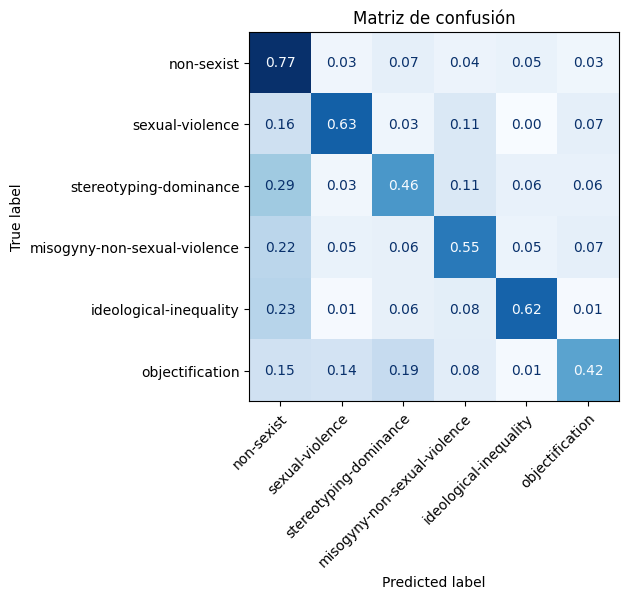

In [26]:
y_preds = np.argmax(preds_output.predictions, axis=1)
cm = confusion_matrix(TWS_Encoded["val"]['label'], y_preds, normalize="true")
labels = ['non-sexist', 'sexual-violence', 'stereotyping-dominance', 'misogyny-non-sexual-violence', 'ideological-inequality', 'objectification']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
# Crear una figura y un eje
fig, ax = plt.subplots()
# Plotear la matriz de confusión
disp.plot(cmap="Blues", values_format=".2f", colorbar=False, ax=ax)
# Ajustar las etiquetas de la línea x
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.title("Matriz de confusión")
plt.show()

In [27]:
preds_output = trainer.predict(TWS_Encoded["test"])
preds_output.metrics



{'test_loss': 0.9450510144233704,
 'test_accuracy': 0.6699029126213593,
 'test_f1': 0.6707913069240725,
 'test_runtime': 8.488,
 'test_samples_per_second': 133.483,
 'test_steps_per_second': 8.365}

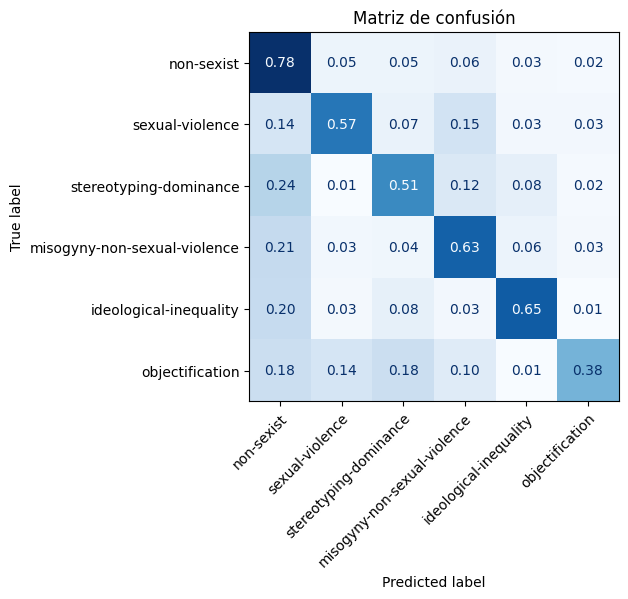

In [28]:
y_preds = np.argmax(preds_output.predictions, axis=1)
cm = confusion_matrix(TWS_Encoded["test"]['label'], y_preds, normalize="true")
labels = ['non-sexist', 'sexual-violence', 'stereotyping-dominance', 'misogyny-non-sexual-violence', 'ideological-inequality', 'objectification']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
# Crear una figura y un eje
fig, ax = plt.subplots()
# Plotear la matriz de confusión
disp.plot(cmap="Blues", values_format=".2f", colorbar=False, ax=ax)

# Ajustar las etiquetas de la línea x
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.title("Matriz de confusión")
plt.show()

# Análisis del validation loss

In [29]:
#Análisis de la perdida del modelo:

from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [30]:
TWS_Encoded["val"] = TWS_Encoded["val"].map(forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/1133 [00:00<?, ? examples/s]

In [31]:
def label_int2str(label):
    return Etiqueta_dato[str(label)]

In [32]:
TWS_Encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = TWS_Encoded["val"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

In [33]:
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
pd.set_option('display.width', None)  # Ancho de la pantalla no limitado
pd.set_option('display.max_colwidth', None)  # Mostrar el texto completo en la
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
251,"@AlleyDalley Tuvo que ser un puritano expresando impulsos reprimidos, estoy seguro",sexual-violence,non-sexist,5.626622
523,Y voy por un culo así el año que viene https://t.co/n41R03x8u6,objectification,non-sexist,5.468640
215,@Benholm @hari_fightclub @margaritaevna95 Es una táctica clásica usada contra las mujeres durante milenios para debilitarlas reduciéndolas a objetos. Así que esa es mi desvarío feminista.. No todo el feminismo es malo. Algunas observaciones siguen siendo válidas incluso ahora,objectification,ideological-inequality,5.248203
101,"@TaniaRi71155160 @kondepatula13 Que bueno no es necesario mostrar las tetas, cagar en la calle o andar a raja pela para ser iguales",ideological-inequality,objectification,5.120451
179,"#NoEsBromaY como si no fuera suficiente, tendrá que pagar una pensión alimenticia ...https://t.co/5fYh13p2WO",ideological-inequality,non-sexist,4.906923
100,lOoK oUT tHe fEmINAZi hAs lOgGeD oN debe estar en su período https://t.co/ZgFgYoOhx0,ideological-inequality,non-sexist,4.879378
874,Hace un año pasé un gran día con esta pedazo mujer. ¿La veis guapa? Pues no sabéis como es por dentro... Gracias por abrirme las puertas de tu casa y por estar ahí @elisabethreyesmartin Eres una mujer maravillosa y con un gran corazón. https://t.co/JX92GREFXK,objectification,non-sexist,4.795927
847,@Imthissexyinrl @soulbrotha215 @Inflatable8D No te culpo en absoluto. Yo tampoco querría ir allí. Parece que el período de mujeres &amp; niños no es seguro allí.,misogyny-non-sexual-violence,non-sexist,4.743957
304,@sycnan5 Sencillamente hermosa mujer Dios te bendiga siempre por ser la creación más perfecta y maravillosa de Dios para el mundo,objectification,non-sexist,4.723976
364,https://www.mediterraneodigital.com/espana/cataluna/los-terroristas-de-barcelona-se-iban-de-putas-mientras-cobraban-ayudas-sociales.html,objectification,non-sexist,4.720348


In [34]:
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
pd.set_option('display.width', None)  # Ancho de la pantalla no limitado
pd.set_option('display.max_colwidth', None)  # Mostrar el texto completo en la
# Ordena y muestra las primeras 10 filas
df_test.sort_values("loss", ascending=True).head(10)


,text,label,predicted_label,loss
1019,Quito merece ser lo que fue. Recuperémoste la libertad y el trabajo para rescatar a la ciudad del abandono y la desidia. La @CorteConstEcu debe devolver a lo s quiteños sus derechos. #TrabajoYLibertad #DerechosYTrabajo https://t.co/qIue7KS0Gh,non-sexist,non-sexist,0.025677
393,Resulta que hoy es el día de la juventud y no me queda más que felicitar al único que lo merece. Feliz día Gai! que la llama de tu juventud nunca se apague :),non-sexist,non-sexist,0.026210
484,@danieldessinger @StevePieczenik (1 de 2) Él lo dio el 4 de diciembre....Vi a Jesús y a un soldado de pie uno al lado del otro en la cima de esta gran colina.Ambos mirando hacia mí y mirando hacia la hermosa luz.Jesús era un hombre enorme.Viento soplaba su túnica y su pelo.Pero yo estaba muy lejos mirándolos al fondo de la colina.,non-sexist,non-sexist,0.026376
762,@FiftyShadezOfMe @Just_Juicy_Rice Que es un estado de ánimoHaría cualquier cosa que alguien me pidiera que rn,non-sexist,non-sexist,0.026413
853,"@funkymxnks Hombre pero noel no se refería a los conciertos del 94 95... que tb por eso aclaro que la Mayoría de veces, el unplugged fue porque no se sentía cómodo haciendo un acústico y como se comunican tan bien diría pos me emborracho y lo veo desde el palco a tomar x culo el enano",non-sexist,non-sexist,0.026629
587,Viendo las fotos del añonuevo de 2017 a 2018 me doy cuenta de lo gorda que puedo llegar a estarVaya momento ese,non-sexist,non-sexist,0.027063
1051,Servicio de recogida CURB-SIDE...Damas que usted no necesita salir de su coche.Compras en línea:https://t.co/HKhoFuDjopGorgeous Downtown Burlington 2082 Pine Street L7R1G2 https://t.co/l1qvUcawjn,non-sexist,non-sexist,0.027105
894,@MichaelsCoDub Eres mi héroe de 2020. Cuando nuestra chica terminó su grado de enfermería este año.. Ella nos compró un vale para su lugar. Espero que estamos prohibidos xxx feliz Navidad para ti y la familia x,non-sexist,non-sexist,0.027245
709,Honestamente estoy tentado a ir directamente a la batalla de los dioses pero siento que debería al menos ver la primera película más fría y la historia de los baúles,non-sexist,non-sexist,0.027313
608,@Chucky1369420 Aye man todo es bueno hermano. Mientras estés a salvo y pasando un buen rato hombre. #justo comprobando,non-sexist,non-sexist,0.027464


In [35]:
model.save_pretrained(
  os.path.join(path_model, 'Twitter/twhin-finetuned-TaskB'))
tokenizer.save_pretrained(
    os.path.join(path_model, 'Twitter/twhin-finetuned-TaskB'))

('/content/drive/MyDrive/Twitter/twhin-finetuned-TaskB/tokenizer_config.json',
 '/content/drive/MyDrive/Twitter/twhin-finetuned-TaskB/special_tokens_map.json',
 '/content/drive/MyDrive/Twitter/twhin-finetuned-TaskB/tokenizer.json')